# 데이터셋 다운로드(1.5GB)
https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [17]:
!pip install piexif


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# train_test_split

## train_test_split 함수 생성

In [18]:
# 준비된 데이터셋을 Train / Test 파일로 분할하는 코드입니다.
import os
import random
import shutil
import piexif

def train_test_split(src_folder, train_size = 0.8):
	# 기존 폴더를 삭제하고 깨끗한 상태로 시작한다. 
	shutil.rmtree(src_folder+'Train/Cat/', ignore_errors=True)
	shutil.rmtree(src_folder+'Train/Dog/', ignore_errors=True)
	shutil.rmtree(src_folder+'Test/Cat/', ignore_errors=True)
	shutil.rmtree(src_folder+'Test/Dog/', ignore_errors=True)

	# train 폴더와 test 폴더를 새로 생성한다.
	os.makedirs(src_folder+'Train/Cat/')
	os.makedirs(src_folder+'Train/Dog/')
	os.makedirs(src_folder+'Test/Cat/')
	os.makedirs(src_folder+'Test/Dog/')

	# 고양이 이미지와 개 이미지 개수를 가져온다.
	_, _, cat_images = next(os.walk(src_folder+'Cat/'))
	files_to_be_removed = ['Thumbs.db', '666.jpg', '835.jpg']
	for file in files_to_be_removed:
		cat_images.remove(file)
	num_cat_images = len(cat_images)
	num_cat_images_train = int(train_size * num_cat_images)
	num_cat_images_test = num_cat_images - num_cat_images_train

	_, _, dog_images = next(os.walk(src_folder+'Dog/'))
	files_to_be_removed = ['Thumbs.db', '11702.jpg']
	for file in files_to_be_removed:
		dog_images.remove(file)
	num_dog_images = len(dog_images)
	num_dog_images_train = int(train_size * num_dog_images)
	num_dog_images_test = num_dog_images - num_dog_images_train

	# 이미지를 무작위로 골라 train 폴더와 test 폴더로 나눈다.
	cat_train_images = random.sample(cat_images, num_cat_images_train)
	for img in cat_train_images:
		shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Train/Cat/')
	cat_test_images  = [img for img in cat_images if img not in cat_train_images]
	for img in cat_test_images:
		shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Test/Cat/')

	dog_train_images = random.sample(dog_images, num_dog_images_train)
	for img in dog_train_images:
		shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Train/Dog/')
	dog_test_images  = [img for img in dog_images if img not in dog_train_images]
	for img in dog_test_images:
		shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Test/Dog/')

	# 데이터셋에서 잘못된 EXIF 데이터를 제거한다.
	remove_exif_data(src_folder+'Train/')
	remove_exif_data(src_folder+'Test/')

# 마이크로소프트 데이터셋에 있는 잘못된 EXIF 데이터를 제거하는 헬퍼 함수
def remove_exif_data(src_folder):
	_, _, cat_images = next(os.walk(src_folder+'Cat/'))
	for img in cat_images:
		try:
			piexif.remove(src_folder+'Cat/'+img)
		except:
			pass

	_, _, dog_images = next(os.walk(src_folder+'Dog/'))
	for img in dog_images:
		try:
			piexif.remove(src_folder+'Dog/'+img)
		except:
			pass

## test_train_split 함수 적용

In [19]:
# 실제로 분할하는 코드
import os
import warnings
warnings.filterwarnings("ignore")

# 이미지 데이터가 저장된 폴더 경로를 설정합니다.
src = 'C:\\Users\\qq\\Downloads\\20240904 수업 자료\\PetImages/'

# 데이터셋이 있는지 확인합니다.
if not os.path.isdir(src):
    print("src path error")
    # 데이터셋이 없으면 프로그램을 종료합니다.
    quit()  

# 만약 폴더가 없으면 train_test_split 함수를 호출하여 폴더를 생성합니다.
if not os.path.isdir(src + 'Train/'):
    train_test_split(src)

# CNN

## CNN 모델 정의

In [30]:
import os
import warnings
warnings.filterwarnings("ignore")

# 이미지 데이터가 저장된 폴더 경로를 설정합니다.
src = 'C:\\Users\\qq\\Downloads\\20240904 수업 자료\\PetImages/'

# 필요 라이브러리 추가
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # 이미지 데이터를 다루기 위한 도구입니다.
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델의 하이퍼파라미터를 정의합니다.
FILTER_SIZE = 3         # 필터의 크기 설정
NUM_FILTERS = 32        # 필터의 개수 설정
INPUT_SIZE = 32         # 입력 이미지의 크기 설정(32 X 32)
MAXPOOL_SIZE = 2        # 풀링 크기 설정(2 X 2)
BATCH_SIZE = 16         # 배치 크기 설정
EPOCHS = 10             # 에폭 수 설정

# 신경망 모델을 만듭니다.
# input_shape=(32, 32, 3)
# input_shape=(INPUT_SIZE, INPUT_SIZE, 3)
model = Sequential([
    Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), input_shape=(INPUT_SIZE, INPUT_SIZE, 3),activation='relu'),
    MaxPooling2D(pool_size=(MAXPOOL_SIZE, MAXPOOL_SIZE)),
    
    Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), activation='relu'),
    MaxPooling2D((MAXPOOL_SIZE, MAXPOOL_SIZE)),
    Dropout(0.2),

    Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), activation='relu'),

    Flatten(),
    Dense(32, activation='relu'),

    Dense(1, activation='sigmoid')
])

# 모델 체크포인트(ModelCheckpoint)를 설정합니다.
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# 모델을 컴파일합니다, 'adam' 옵티마이저를 사용하여 모델을 컴파일합니다. 손실 함수는 'binary_crossentropy'를 사용하며, 정확도를 평가합니다.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


### 데이터를 폴더에서 불러오기

In [31]:
# 이미지 전처리 및 데이터 로딩을 위한 생성기를 만듭니다(이미지를 0과 1 사이로 정규화합니다.)
training_data_generator = ImageDataGenerator(rescale=1./255)
testing_data_generator = ImageDataGenerator(rescale=1./255)


# 훈련 데이터를 폴더에서 불러옵니다.
training_set = training_data_generator.flow_from_directory(
    os.path.join(src, 'Train/'),            # 훈련 데이터가 있는 폴더 경로
    target_size=(INPUT_SIZE, INPUT_SIZE),   # 이미지를 INPUT_SIZExINPUT_SIZE 크기로 바꿉니다.
    batch_size=BATCH_SIZE,                  # 한 번에 BATCH_SIZE개의 이미지를 모델에 제공합니다.
    class_mode='binary'                     # 이미지를 두 가지(예: 고양이/개)로 분류합니다.
)

# 테스트 데이터를 폴더에서 불러옵니다.
test_set = testing_data_generator.flow_from_directory(
    os.path.join(src, 'Test/'),             # 테스트 데이터가 있는 폴더 경로
    target_size=(INPUT_SIZE, INPUT_SIZE),   # 이미지를 INPUT_SIZExINPUT_SIZE 크기로 바꿉니다.
    batch_size=BATCH_SIZE,                  # 한 번에 BATCH_SIZE개의 이미지를 모델에 제공합니다.
    class_mode='binary'                     # 이미지를 두 가지(예: 고양이/개)로 분류합니다.
)

Found 19997 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Model fit

In [32]:
# 모델을 훈련시킵니다.
model.fit(training_set, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpoint])

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 189s 149ms/step - accuracy: 0.5290 - loss: 0.6858
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6881 - loss: 0.5850
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.7337 - loss: 0.5270
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.7589 - loss: 0.4924
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.7756 - loss: 0.4741
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.7885 - loss: 0.4519
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.7959 - loss: 0.4372
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8116 - loss: 0.4122
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.8164 - loss: 0.3987
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.8234 - loss: 0.3855


## loss, score 평가

In [33]:
# 테스트 데이터로 모델의 성능을 평가합니다.
# steps=100: 테스트 데이터에서 100개의 배치를 평가합니다.
score = model.evaluate(test_set, steps=100)

# 모델의 성능을 출력합니다.
for idx, metric in enumerate(model.metrics_names):
    # 각 메트릭의 이름과 해당 메트릭의 값을 출력합니다.
    print("{}: {}".format(metric, score[idx]))

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.8057 - loss: 0.4381
loss: 0.44056403636932373
compile_metrics: 0.7975000143051147


## confusion matrix, classificaion report

In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 예측 결과를 저장할 리스트
all_predictions = []
all_labels = []


# test_set 클래스가 반복 가능한 객체(파일)입니다.
for _ in range(len(test_set)):
    test_images, test_labels = next(test_set) 
    predictions = model.predict(test_images) 
    
    # 예측 결과를 이진 분류에 맞게 변환합니다.
    predictions = (predictions > 0.5).astype(int)
    
    all_predictions.extend(predictions.flatten())   # 예측 결과를 1차원으로 변환, 리스트에 추가
    all_labels.extend(test_labels.flatten())        # 실제 라벨을 1차원으로 변환, 리스트에 추가


# 혼동 행렬을 계산합니다.
cm = confusion_matrix(all_labels ,all_predictions)

# 분류 리포트를 출력합니다.
print(classification_report(all_labels , all_predictions))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

## 예측 결과 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

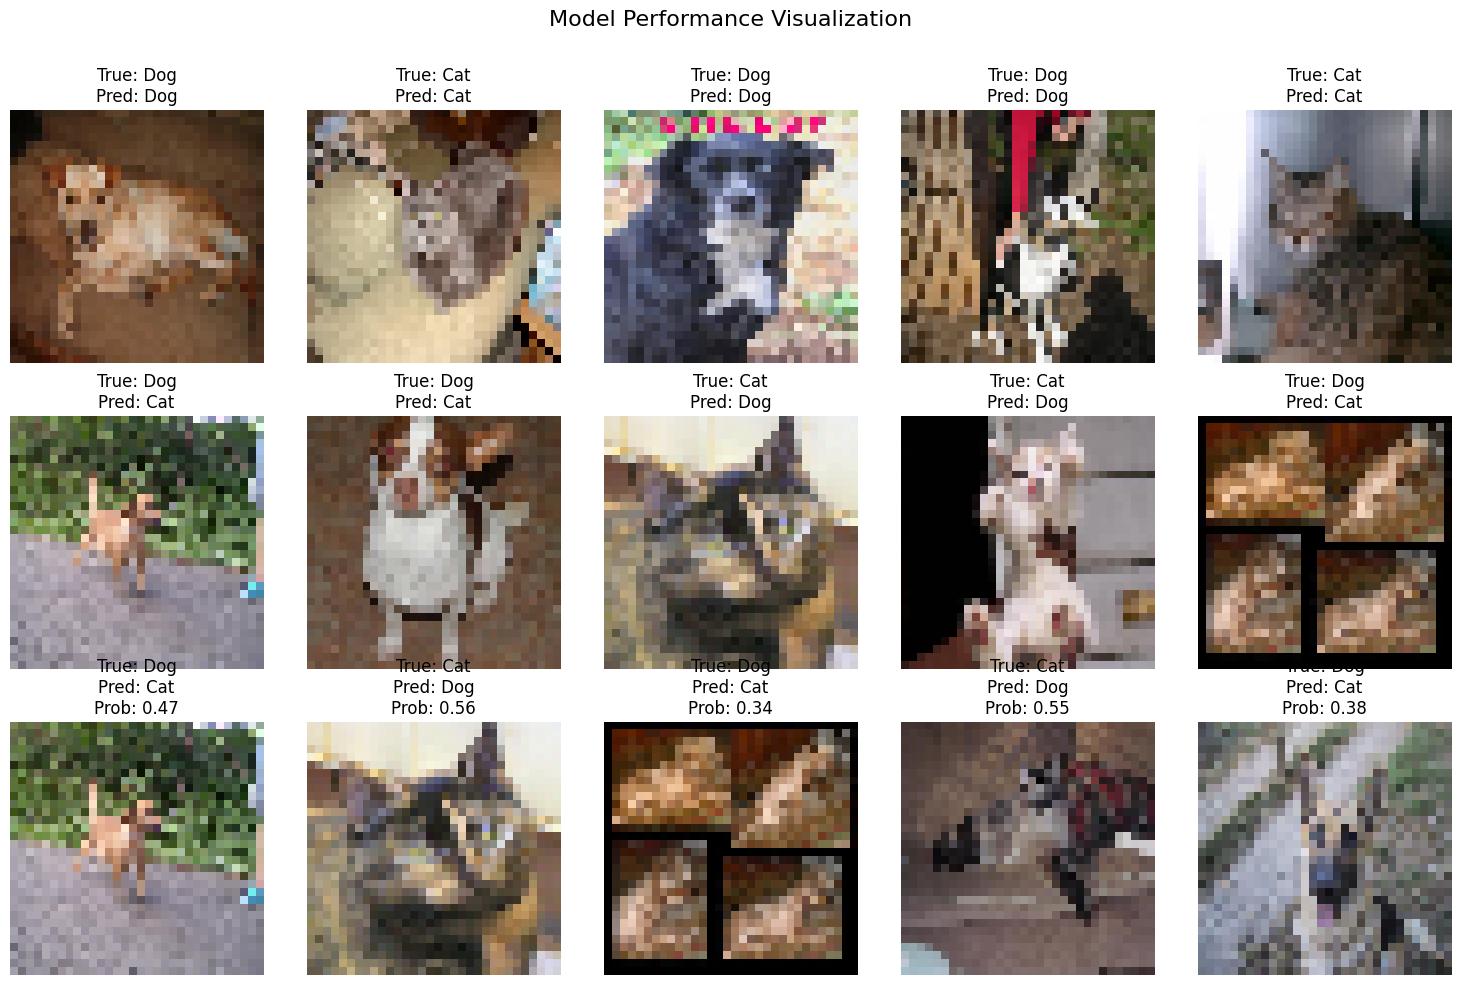

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 예측 결과를 저장할 리스트
all_images = []
all_labels = []
all_predictions = []
all_probabilities = []

# 데이터 배치에서 예측을 수행
for _ in range(len(test_set)):
    test_images, test_labels = next(test_set)  # 배치 단위로 이미지와 라벨을 가져옵니다.
    predictions = model.predict(test_images)  # 모델로 예측을 수행합니다.
    
    # 예측 결과를 이진 분류에 맞게 변환합니다.
    probabilities = predictions.flatten()  # 예측 확률을 평평하게 만듭니다.
    predictions = (probabilities > 0.5).astype(int)
    
    # 예측 결과와 실제 라벨, 확률을 리스트에 추가합니다.
    all_images.extend(test_images)  # 이미지를 리스트에 추가합니다.
    all_labels.extend(test_labels.flatten())  # 실제 라벨을 평평하게 만들어 리스트에 추가합니다.
    all_predictions.extend(predictions.flatten())  # 예측 결과를 평평하게 만들어 리스트에 추가합니다.
    all_probabilities.extend(probabilities)  # 예측 확률을 리스트에 추가합니다

# 이미지와 라벨을 시각적으로 확인할 수 있는 함수
def plot_images(images, labels, predictions, probabilities, correct_indices, incorrect_indices, uncertain_indices, title):
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # 맞은 사진
    for i, idx in enumerate(correct_indices[:5]):
        ax = axes[0, i]
        ax.imshow(images[idx])
        ax.set_title(f"True: {'Dog' if labels[idx] == 1 else 'Cat'}\nPred: {'Dog' if predictions[idx] == 1 else 'Cat'}")
        ax.axis('off')
    
    # 틀린 사진
    for i, idx in enumerate(incorrect_indices[:5]):
        ax = axes[1, i]
        ax.imshow(images[idx])
        ax.set_title(f"True: {'Dog' if labels[idx] == 1 else 'Cat'}\nPred: {'Dog' if predictions[idx] == 1 else 'Cat'}")
        ax.axis('off')
    
    # 아깝게 틀린 사진
    for i, idx in enumerate(uncertain_indices[:5]):
        ax = axes[2, i]
        ax.imshow(images[idx])
        ax.set_title(f"True: {'Dog' if labels[idx] == 1 else 'Cat'}\nPred: {'Dog' if predictions[idx] == 1 else 'Cat'}\nProb: {probabilities[idx]:.2f}")
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 맞은 사진, 틀린 사진, 아깝게 틀린 사진의 인덱스를 구합니다.
correct_indices = [i for i in range(len(all_labels)) if all_labels[i] == all_predictions[i]]
incorrect_indices = [i for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]
uncertain_indices = [i for i in range(len(all_labels)) if abs(all_probabilities[i] - 0.5) < 0.2 and all_labels[i] != all_predictions[i]]

# 맞은 사진, 틀린 사진, 아깝게 틀린 사진을 시각적으로 확인합니다.
plot_images(all_images, all_labels, all_predictions, all_probabilities, correct_indices, incorrect_indices, uncertain_indices, "Model Performance Visualization")


# VGG16 사전 학습 모델 사용

사용할 수 있는 모델 종류
- https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

src = 'C:\\Users\\qq\\Downloads\\20240904 수업 자료\\PetImages/'

# 데이터셋이 있는지 먼저 확인한다. 없다면 내려 받아야 한다
if not os.path.isdir(src):
    print("src path error")
    quit()

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 초매개변수 정의
INPUT_SIZE = 32 # 128, 48
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3


base_model = VGG16(include_top=False, weights='imagenet',input_tenser=Input(shape=(INPUT_SIZE, INPUT_SIZE, 3)))

# 사전 학습된 레이어 고정
for layer in base_model.layers:
    layer.trainable = False

# 모델 구성 : 신경망 맨 아래에 완전 연결 레이어 추가
vgg_model = Model(inputs=base_model.input, outputs=predictions)

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)


# 모델 체크포인트(ModelCheckpoint) 설정
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# 모델 컴파일 (adam, binary_crossentropy)
optimizer = Adam(learning_rate=0.001)
vgg_model.compile(optimizer=optimizer, loss='binary_crossentropy')


# 데이터 정규화
training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale = 1./255)

# 폴더에서 데이터 불러오기
training_set = training_data_generator.flow_from_directory(src+'Train/',
                                                target_size = (INPUT_SIZE, INPUT_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary')

test_set = testing_data_generator.flow_from_directory(src+'Test/',
                                             target_size = (INPUT_SIZE, INPUT_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'binary')

TypeError: VGG16() got an unexpected keyword argument 'input_tenser'

### 모델 학습

In [ ]:
# 모델 학습
vgg_model.fit()
# 모델 평가(ecvaluate)

for idx, metric in enumerate(vgg_model.metrics_names):
    print("{}: {}".format(metric, score[idx]))


## loss, score 출력

In [ ]:
# 테스트 데이터로 모델의 성능을 평가합니다.
# test_set: 테스트 데이터를 사용하여 모델의 성능을 측정합니다.
# steps=100: 테스트 데이터에서 100개의 배치를 평가합니다.


# 모델의 성능을 출력합니다.
for idx, metric in enumerate(vgg_model.metrics_names):
    # 각 메트릭의 이름과 해당 메트릭의 값을 출력합니다.
    print("{}: {}".format(metric, score[idx]))

## 결과 시각화

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 예측 결과를 저장할 리스트
all_images = []
all_labels = []
all_predictions = []
all_probabilities = []

# 데이터 배치에서 예측을 수행
for _ in range(len(test_set)):
    test_images, test_labels = next(test_set)  # 배치 단위로 이미지와 라벨을 가져옵니다.
    predictions = vgg_model.predict(test_images)  # 모델로 예측을 수행합니다.
    
    # 예측 결과를 이진 분류에 맞게 변환합니다.
    probabilities = predictions.flatten()  # 예측 확률을 평평하게 만듭니다.
    predictions = (probabilities > 0.5).astype(int)
    
    # 예측 결과와 실제 라벨, 확률을 리스트에 추가합니다.
    all_images.extend(test_images)  # 이미지를 리스트에 추가합니다.
    all_labels.extend(test_labels.flatten())  # 실제 라벨을 평평하게 만들어 리스트에 추가합니다.
    all_predictions.extend(predictions.flatten())  # 예측 결과를 평평하게 만들어 리스트에 추가합니다.
    all_probabilities.extend(probabilities)  # 예측 확률을 리스트에 추가합니다

# 이미지와 라벨을 시각적으로 확인할 수 있는 함수
def plot_images(images, labels, predictions, probabilities, correct_indices, incorrect_indices, uncertain_indices, title):
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # 맞은 사진
    for i, idx in enumerate(correct_indices[:5]):
        ax = axes[0, i]
        ax.imshow(images[idx])
        ax.set_title(f"True: {'Dog' if labels[idx] == 1 else 'Cat'}\nPred: {'Dog' if predictions[idx] == 1 else 'Cat'}")
        ax.axis('off')
    
    # 틀린 사진
    for i, idx in enumerate(incorrect_indices[:5]):
        ax = axes[1, i]
        ax.imshow(images[idx])
        ax.set_title(f"True: {'Dog' if labels[idx] == 1 else 'Cat'}\nPred: {'Dog' if predictions[idx] == 1 else 'Cat'}")
        ax.axis('off')
    
    # 아깝게 틀린 사진
    for i, idx in enumerate(uncertain_indices[:5]):
        ax = axes[2, i]
        ax.imshow(images[idx])
        ax.set_title(f"True: {'Dog' if labels[idx] == 1 else 'Cat'}\nPred: {'Dog' if predictions[idx] == 1 else 'Cat'}\nProb: {probabilities[idx]:.2f}")
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 맞은 사진, 틀린 사진, 아깝게 틀린 사진의 인덱스를 구합니다.
correct_indices = [i for i in range(len(all_labels)) if all_labels[i] == all_predictions[i]]
incorrect_indices = [i for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]
uncertain_indices = [i for i in range(len(all_labels)) if abs(all_probabilities[i] - 0.5) < 0.2 and all_labels[i] != all_predictions[i]]

# 맞은 사진, 틀린 사진, 아깝게 틀린 사진을 시각적으로 확인합니다.
plot_images(all_images, all_labels, all_predictions, all_probabilities, correct_indices, incorrect_indices, uncertain_indices, "Model Performance Visualization")

# 혼동 행렬을 계산합니다.
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# 분류 리포트를 출력합니다.
report = classification_report(all_labels, all_predictions)
print("Classification Report:")
print(report)

# (추가) Resnet34 또는 Resnet50 사용해보세요